# Severless Deep Learning

## Overview

* Assume a client wants to sell pants:
    * takes a pitcure of the pants
    * uploads the image
    * send the picture to the "cloth-classification-service"
    * picture is clssified as pants
* This lecture focuses on how a model can be deployed
    * use lambda (service from AWS)

## AWS Lambda
* Use AWS lambda to deploy our trained model
* Intro to AWS Lambda
    * "Run code without thinking about servers"
    * Service from AWS
    * We only need to write a function and don't need to take care about servers
    * This is done directly on AWS
    * You only need to pay, when the lambda function is used, when there are no requests, you don't need to pay
* Serverless to serverfull

![lambda](Screenshot_01.png)

## TensorFlow Lite
* Why not TensorFlow
    * Smaller than Tensorflow
    * Historically AWS did not allow such big images (may not be true any more)
    * Have to pay more, especially when first initialized, because it takes longer
    * Faster than Tensorflow
    * Tensorflow lite only focuses only on inference! Is not used to train a model, i.e. to use tendorflow lite we need to train our model first and then convert it to Tensorflow lite
* Converting the model
* Using TF-Lite model to make predictions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

import numpy as np

In [2]:
!python -V

Python 3.9.7


In [3]:
tf.__version__

'2.4.1'

In [4]:
# use a model trained in the previous lecture
clothing_model = "../week8/xception_v4_05_0.850.h5"

In [5]:
model = keras.models.load_model(clothing_model)

* Use this model to classify a picture of pants

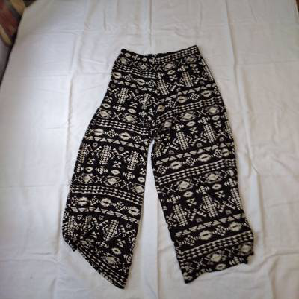

In [6]:
image = "../data/clothing-dataset-small/test/pants/01033304-f9a4-48c4-af65-677512880fae.jpg"
img = load_img(image, target_size=(299, 299))
img

In [7]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

preds = model.predict(X)
preds

array([[-0.19577762, -3.4405227 , -1.1562667 ,  0.9988061 ,  9.197068  ,
        -1.5590703 , -4.5740395 ,  3.946617  , -1.3878585 , -2.5213532 ]],
      dtype=float32)

In [8]:
classes = ['dress',
 'hat',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

dict(zip(classes, preds[0]))

{'dress': -0.19577762,
 'hat': -3.4405227,
 'longsleeve': -1.1562667,
 'outwear': 0.9988061,
 'pants': 9.197068,
 'shirt': -1.5590703,
 'shoes': -4.5740395,
 'shorts': 3.946617,
 'skirt': -1.3878585,
 't-shirt': -2.5213532}

### Convert Tensorflow model to Tensorflow Lite model

* documentation: tensorflow.org/lite/convert

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tf_lite_model = converter.convert()

with open('clothing_model.tflite', 'wb') as f_out:
    f_out.write(tf_lite_model)

INFO:tensorflow:Assets written to: /tmp/tmpirbhwtry/assets


In [10]:
!ls

clothing_model.tflite  Lecture_9_serverless.ipynb  Screenshot_01.png


### Use the Model

In [11]:
import tensorflow.lite as tflite

In [12]:
# load the model
interpreter = tflite.Interpreter(model_path="clothing_model.tflite")
# load the weights (in keras this is automatically)
interpreter.allocate_tensors()

In [13]:
interpreter.get_input_details()

[{'name': 'input_13',
  'index': 0,
  'shape': array([  1, 299, 299,   3], dtype=int32),
  'shape_signature': array([ -1, 299, 299,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

* 'index' says, where the input should go

In [14]:
input_index = interpreter.get_input_details()[0]['index']

In [15]:
interpreter.get_output_details()

[{'name': 'Identity',
  'index': 229,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([-1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [16]:
output_index = interpreter.get_output_details()[0]['index']

In [17]:
interpreter.set_tensor(input_index, X)

* invoke the computaios in the neural network

In [18]:
interpreter.invoke()

* Get the predictions

In [19]:
preds = interpreter.get_tensor(output_index)
preds

array([[-0.1957762 , -3.4405243 , -1.1562665 ,  0.99880755,  9.197067  ,
        -1.5590683 , -4.574042  ,  3.946616  , -1.3878607 , -2.5213554 ]],
      dtype=float32)

In [20]:
dict(zip(classes, preds[0]))

{'dress': -0.1957762,
 'hat': -3.4405243,
 'longsleeve': -1.1562665,
 'outwear': 0.99880755,
 'pants': 9.197067,
 'shirt': -1.5590683,
 'shoes': -4.574042,
 'shorts': 3.946616,
 'skirt': -1.3878607,
 't-shirt': -2.5213554}

* Problem: We used Tensorflow to preprocess the images
* Now: **Remove Tensorflow dependency**

In [21]:
from PIL import Image

In [22]:
with Image.open(image) as img:
    img = img.resize((299, 299), Image.NEAREST)

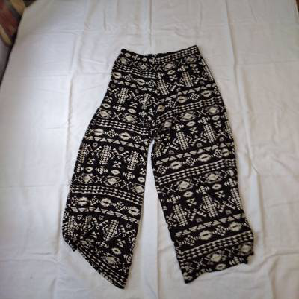

In [23]:
img

In [24]:
# copy the relavant code from xception preprocessing function
def preprocess_input(x):
    x /= 127.5
    x -= 1.
    return x

In [25]:
x = np.array(img, dtype="float32")
X = np.array([x])
X = preprocess_input(X)

**Simpler Way:**
* Use library ```keras_image_helper```

In [27]:
from keras_image_helper import create_preprocessor

In [28]:
preprocessor = create_preprocessor('xception', target_size=(299,299))

In [31]:
X = preprocessor.from_path(image)

In [32]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [33]:
dict(zip(classes, preds[0]))

{'dress': -0.1957762,
 'hat': -3.4405243,
 'longsleeve': -1.1562665,
 'outwear': 0.99880755,
 'pants': 9.197067,
 'shirt': -1.5590683,
 'shoes': -4.574042,
 'shorts': 3.946616,
 'skirt': -1.3878607,
 't-shirt': -2.5213554}

At the moment we use Tensorflow Lite, which comes from Tensorflow
* documentation: tensorflow.org/lite
* Install tensorflow Lite part, that only does inference

In [37]:
! pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 2.2 MB 5.1 MB/s eta 0:00:01


* Replace the import

In [40]:
# import tensorflow.tflite as tflite
import tflite_runtime.interpreter as tflite

In [41]:
# load the model
interpreter = tflite.Interpreter(model_path="clothing_model.tflite")
# load the weights (in keras this is automatically)
interpreter.allocate_tensors()

In [44]:
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [45]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

In [46]:
dict(zip(classes, preds[0]))

{'dress': -0.19577676,
 'hat': -3.440524,
 'longsleeve': -1.156267,
 'outwear': 0.99880654,
 'pants': 9.197064,
 'shirt': -1.5590702,
 'shoes': -4.5740366,
 'shorts': 3.9466114,
 'skirt': -1.3878584,
 't-shirt': -2.5213544}

* For deployment on AWS Lambda, we only want to use the inference part

## Preparing the Lambda code
* Moving the code from notebook to script
* Testing it locally

## Creating the Lambda function
* Publishing the image to AWS ECR
* Creating the function
* Configuring it
* Testing the function from AWS console
* Pricing

## API Gateway: exposing the lambda function 
* Creating and configuring the gateway